In [161]:
%matplotlib inline
import d2lzh as d2l
from mxnet import autograd,gluon,nd,init
from mxnet.gluon import data as gdata,loss as gloss,nn
import numpy as np
import pandas as pd

In [162]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [163]:
train_data.shape,test_data.shape

((1460, 81), (1459, 80))

In [164]:
train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]]

,Id,MSSubClass,MSZoning,LotFrontage,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,WD,Normal,208500
1,2,20,RL,80.0,WD,Normal,181500
2,3,60,RL,68.0,WD,Normal,223500
3,4,70,RL,60.0,WD,Abnorml,140000


In [165]:
train_data.drop(train_data[(train_data['GrLivArea'] > 4000) & (train_data['SalePrice']<300000)].index,inplace=True)

In [166]:
all_features = pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))

In [167]:
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
all_features[numeric_features] = all_features[numeric_features].fillna(0)

In [168]:
all_features = pd.get_dummies(all_features,dummy_na=True)
all_features.shape

(2917, 330)

In [169]:
n_train = train_data.shape[0]
train_features = nd.array(all_features[:n_train].values)
test_features = nd.array(all_features[n_train:].values)
train_labels = nd.array(train_data.SalePrice.values).reshape((-1,1))
train_features.shape,test_features.shape,train_labels.shape

((1458, 330), (1459, 330), (1458, 1))

In [170]:
loss = gloss.L2Loss()

def get_net():
    net = nn.Sequential()
    net.add(nn.Dense(300,activation='relu'),nn.Dense(1))
    net.initialize()
    return net

In [171]:
def log_rmse(net,features,labels):
    clipped_preds = nd.clip(net(features),1,float('inf'))
    rmse = nd.sqrt(2*loss(clipped_preds.log(),labels.log()).mean())
    return rmse.asscalar()

def test_rmse(y_hat,y):
    rmse = nd.sqrt(y_hat,y).mean()
    return rmse.asscalar()
a = nd.array([1,2,3])
b = nd.array([2,3,4])
print(test_rmse(a,b))

1.3820881


In [172]:
def train(net,train_features,train_labels,test_features,test_lables,num_epochs,learning_rate,weight_decay,batch_size):
    train_ls,test_ls = [],[]
    train_iter = gdata.DataLoader(gdata.ArrayDataset(train_features,train_labels),batch_size,shuffle=True)
    trainer = gluon.Trainer(net.collect_params(),'adam',{'learning_rate':learning_rate,'wd':weight_decay})
    for epoch in range(num_epochs):
        for X,y in train_iter:
            with autograd.record():
                l = loss(net(X),y)
            l.backward()
            trainer.step(batch_size)
        train_ls.append(log_rmse(net,train_features,train_labels))
        if test_lables is not None:
            test_ls.append(log_rmse(net,test_features,test_lables))
    return train_ls,test_ls

In [173]:
def get_k_fold_data(k,i,X,y):
    assert k>1
    fold_size = X.shape[0] // k
    X_train ,y_train = None,None
    for j in range(k):
        idx = slice(j*fold_size,(j+1)*fold_size)
        X_part,y_part = X[idx,:],y[idx]
        if j==i:
            X_valid,y_valid = X_part,y_part
        elif X_train is None:
            X_train ,y_train = X_part,y_part
        else:
            X_train = nd.concat(X_train,X_part,dim = 0)
            y_train = nd.concat(y_train,y_part,dim=0)
    return X_train,y_train,X_valid,y_valid

In [174]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum = 0,0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        net = get_net()
        a,b,c,d = data
        train_ls,valid_ls = train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse',range(1,num_epochs+1),valid_ls,['train','valid'])
        print('fold % d ,train rmse %f,valid rmse %f' % (i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

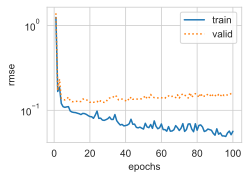

fold  0 ,train rmse 0.056468,valid rmse 0.158458


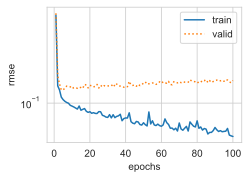

fold  1 ,train rmse 0.047290,valid rmse 0.166247


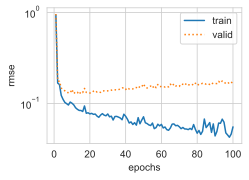

fold  2 ,train rmse 0.055395,valid rmse 0.179676


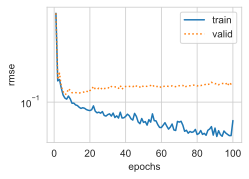

fold  3 ,train rmse 0.065659,valid rmse 0.153900


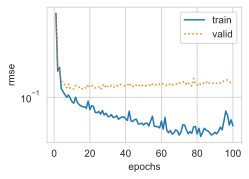

fold  4 ,train rmse 0.053545,valid rmse 0.138486
5-fold validation: avg train rmse 0.055671,avg valid rmse 0.159353


In [175]:
k,num_epochs,lr,weight_decay,batch_size = 5,100,1,0,80
train_l,valid_l = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation: avg train rmse %f,avg valid rmse %f' % (k,train_l,valid_l))

In [176]:
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
    train_l_sum,valid_l_sum = 0,0
    for i in range(k):
        data = get_k_fold_data(k,i,X_train,y_train)
        net = get_net()
        a,b,c,d = data
        train_ls,valid_ls = train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        d2l.semilogy(range(1,num_epochs+1),train_ls,'epochs','rmse',range(1,num_epochs+1),valid_ls,['train','valid'])
        print('fold % d ,train rmse %f,valid rmse %f' % (i,train_ls[-1],valid_ls[-1]))
    return train_l_sum/k,valid_l_sum/k

In [18]:
k,num_epochs,lr,weight_decay,batch_size = 5,100,1,0,80
train_l,valid_l = k_fold(k,train_features,train_labels,num_epochs,lr,weight_decay,batch_size)
print('%d-fold validation: avg train rmse %f,avg valid rmse %f' % (k,train_l,valid_l))

KeyboardInterrupt: 

In [ ]:
def train_and_pred(train_featrues,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
    net = get_net()
    train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
    preds = net(test_features).asnumpy()
    test_data['SalePrice'] = pd.Series(preds.reshape(1,-1)[0])
    sumbmission = pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)
    sumbmission.to_csv('submission.csv',index=False)
train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size)